# La Réunion: download and plot

This minimal notebook downloads a GMRT GeoTIFF for La Réunion and plots it on a map.

- Bounds (lon/lat): [55.0, -21.5, 56.0, -20.5]
- Format: geotiff (medium resolution)
- Output folder: ./data

## Quick import and help

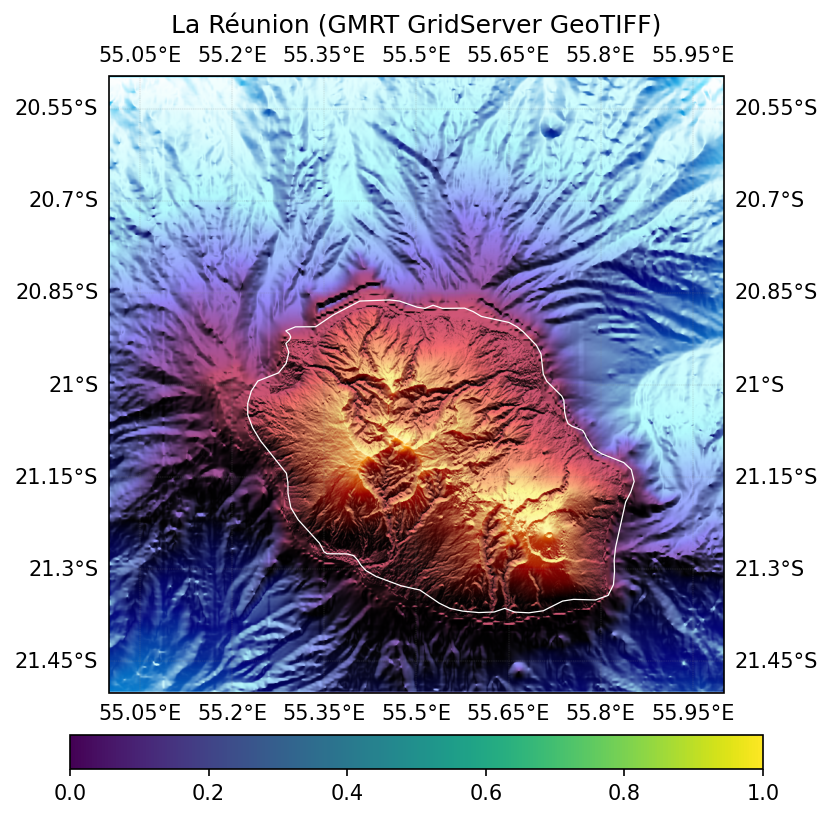

In [2]:
import numpy as np

from pygmrt.tiles import download_tiles, get_path
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rasterio

from matplotlib.colors import LightSource

# La Réunion bbox [west, south, east, north]
bbox = [55.0, -21.5, 56.0, -20.5]

# Force re-download to avoid stale/corrupt cache if needed
result = download_tiles(
    bbox=bbox,
    resolution="low",
    overwrite=False,
)

# Use helper to get a GeoTIFF path (raises if none found)
filepath = get_path(result)

# Plot
with rasterio.open(filepath) as src:
    band1 = src.read(1)
    band1[np.isnan(band1)] = 0
    # replace nans
    vabsmax = np.nanmax(abs(band1))
    b = src.bounds
    extent = (b.left, b.right, b.bottom, b.top)

    fig, ax = plt.subplots(
        subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(9, 6), dpi=150
    )

    ls = LightSource(azdeg=0, altdeg=20)
    hillshade = ls.shade(band1, cmap=plt.cm.managua_r)
    # print(hillshade)

    im = ax.imshow(
        hillshade,
        extent=extent,
        origin="upper",
        transform=ccrs.PlateCarree(),
        # cmap="Greys",
        # vmin=-vabsmax,
        # vmax=vabsmax,
    )
    ax.gridlines(
        draw_labels=True,
        linewidth=0.2,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    ax.coastlines("10m", color="white", linewidth=0.6, zorder=10)
    ax.set_title("La Réunion (GMRT GridServer GeoTIFF)")
    plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, pad=0.06)
    plt.show()